# Quantum computational finance: quantum algorithm for portfolio optimization

In this tutorial, we will work through a concrete example of portfolio optimization. Our goal is to determine how to allocate capital across several assets so that we control risk while still aiming for good returns. To do this, we use historical stock price data to construct a portfolio, that is, the allocation ratios of the assets. The approach is motivated by the methods proposed in References [1,2], where portfolio optimization is identified as a problem that can potentially be accelerated using the HHL algorithm. As a simple practical example, we consider an investment in four major technology stocks and examine how to distribute capital among them in an effective way.

first we need to install some out package to collect stock data.

In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install yfinance

In [3]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from classiq import *

In [4]:
import datetime

import yfinance as yf

codes = ["NVDA", "AAPL", "TSLA", "AMZN"]


start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2024, 12, 31)

data = yf.download(codes, start=start, end=end, auto_adjust=False, progress=False)


df = data["Adj Close"]
display(df.head(10))

Ticker,AAPL,AMZN,NVDA,TSLA
Date,,,,
2024-01-02,183.903244,149.929993,48.141174,248.419998
2024-01-03,182.526215,148.470001,47.542507,238.449997
2024-01-04,180.208130,144.570007,47.971275,237.929993
2024-01-05,179.484940,145.240005,49.069656,237.490005
2024-01-08,183.823975,149.100006,52.223904,240.449997
2024-01-09,183.407898,151.369995,53.110413,234.960007
2024-01-10,184.448074,153.729996,54.319736,233.940002
2024-01-11,183.853683,155.179993,54.791473,227.220001
2024-01-12,184.180634,154.619995,54.679531,218.889999


<Axes: xlabel='Date'>

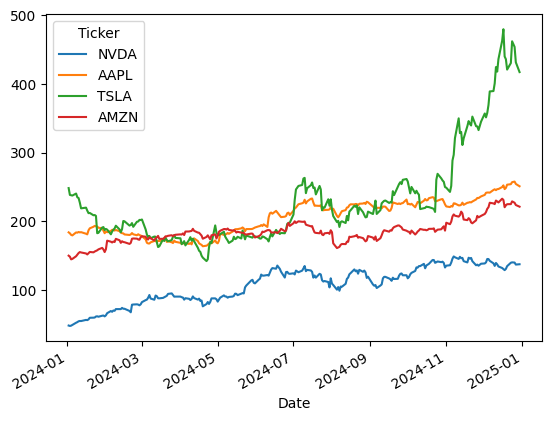

In [5]:
df.loc[:, ["NVDA", "AAPL", "TSLA", "AMZN"]].plot()

## Conversion to Daily Returns

The daily return (rate of change) $y_t$ of an individual stock is defined as follows, letting $t$ be the date:

$$
y_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

It is obtained using `pct_change()` in `pandas`.

In [6]:
daily_return = df.pct_change()
display(daily_return.tail())

Ticker,AAPL,AMZN,NVDA,TSLA
Date,,,,
2024-12-23,0.003065,0.000622,0.036897,0.022657
2024-12-24,0.011478,0.017729,0.003938,0.073572
2024-12-26,0.003176,-0.008732,-0.002068,-0.017630
2024-12-27,-0.013242,-0.014534,-0.020868,-0.049479
2024-12-30,-0.013263,-0.010950,0.003503,-0.033012


## Expected Return

Calculate the expected return $\vec{R}$ for each stock. Here, the arithmetic mean of historical returns is used.

$$
\vec{R} = \frac{1}{T}\sum_{t=1}^{T}\vec{y}_t
$$

In [7]:
expected_return = daily_return.dropna(how="all").mean() * 252
print(expected_return)

Ticker
AAPL    0.338947
AMZN    0.432249
NVDA    1.195816
TSLA    0.721127
dtype: float64


## Variance-Covariance Matrix

The sample unbiased variance-covariance matrix of returns, $\Sigma$, is defined as follows:

$$
\Sigma = \frac{1}{T-1}\sum_{t=1}^{T} (\vec{y}_t - \vec{R})(\vec{y}_t - \vec{R} )^{T}
$$  * Let the return of each asset $i$ be the random variable $R_i$.

* The covariance is:

$$
\mathrm{Cov}(R_i, R_j) = \mathbb{E}\big[(R_i - \mathbb{E}[R_i])(R_j - \mathbb{E}[R_j])\big]
$$


* The matrix aggregating this for all assets is $\Sigma$:

$$
\Sigma =
  \begin{bmatrix}
    \sigma_{00} & \sigma_{01} & \cdots & \sigma_{0n} \\
    \sigma_{10} & \sigma_{11} & \cdots & \sigma_{1n} \\
    \vdots      & \vdots      & \ddots & \vdots      \\
    \sigma_{n0} & \sigma_{n1} & \cdots & \sigma_{nn}
  \end{bmatrix}
  $$
  
Where $\sigma_{ij} = \mathrm{Cov}(R_i, R_j)$.

  * With $\Sigma$, the "diversification effect" is incorporated into the calculation.

  * If assets have a negative correlation with each other, the risk of the entire portfolio decreases.

  * Conversely, if there is a strong positive correlation, the risk reduction effect will not be significant even if assets are diversified.


In [8]:
cov = daily_return.dropna(how="all").cov() * 252
display(cov)

Ticker,AAPL,AMZN,NVDA,TSLA
Ticker,,,,
AAPL,0.050395,0.021255,0.029957,0.046904
AMZN,0.021255,0.079215,0.064514,0.056807
NVDA,0.029957,0.064514,0.276052,0.071397
TSLA,0.046904,0.056807,0.071397,0.405138


## Portfolio Optimization

Having defined the necessary variables, we now proceed to actual portfolio optimization.
We represent the portfolio as a $4$-component vector $\mathbf{w} = (w_0,w_1,w_2,w_3)^T$. This represents the proportion of holdings in each stock; for example, $\mathbf{w}=(1,0,0,0)$ implies a portfolio where $100\%$ of total assets are invested in AAPL stock.

Consider a portfolio that satisfies the following equation:

$$
\mathcal{O} = {\rm min_{\mathbf{w} }}\frac{1}{2}{\mathbf{w}^T}\Sigma\mathbf{w} = \sum_{i} w_i^2 \sigma_{ii} + \sum_{i\neq j} w_i w_j \sigma_{ij}
$$

* The diagonal elements $\sigma_{ii}$ are the variances of each asset (intensity of risk).
* The off-diagonal elements $\sigma_{ij}$ are the covariances between assets (strength of correlation).

Here, the constraints are as follows:

$$
{\rm const.1} = \mathbf{R^Tw}=\mu
$$
$$
{\rm const.2} = \mathbf{1^Tw}=1
$$

Here, $\mathbf{1}$ represents $(1,1,1,1)^T$.

The meanings of the two constraint equations are:

* The expected return of the portfolio (average value of returns) is $\mu$.
* The sum of the weights invested in the portfolio is 1 ($\mathbf{1}=(1,1,1,1)^T$).



Under these conditions, we perform the "minimization of the variance of portfolio returns." This means that when desiring a return of $\mu$ in the future, the best portfolio is one that minimizes the fluctuation (risk) associated with it as much as possible. This type of problem setup is known as the Markowitz Mean-Variance Approach and is one of the foundational concepts of modern financial engineering.


## Lagrange Multiplier Method in Mathematical Optimization

The mathematical optimization problem described above is an optimization problem with equality constraints. By solving this using the **Method of Lagrange Multipliers**, we can find candidates for the local optimal solution.

The Method of Lagrange Multipliers is defined as follows:

$$
\mathcal{L}(x,u) = f(x) + \sum_{i=1}^m u_i g_i(x) \tag{0}
$$

Here, $f(x)$ represents the **objective function**, and the second term represents the **constraint functions**. $u\in R_{d}$ are the Lagrange multipliers.



In the case of our portfolio optimization problem, if we introduce Lagrange multipliers $\eta$ and $\theta$, the Lagrangian is given by:

$$
\mathcal{L}(w,\eta, \theta) = \frac{1}{2}\mathbf{w}^T\Sigma\mathbf{w} + \eta(\mathbf{R}\mathbf{w}-\mu) + \theta(\mathbf{1}^T\mathbf{w}-1) \tag{1}
$$

Since the constraints are linear equations, the optimal solution is guaranteed by just the first-order derivatives. Therefore, we differentiate the Lagrangian function above with respect to the variables $\mathbf{w}, \eta, \text{and } \theta$.

## First-Order Optimality Conditions (KKT Conditions)

$$
\frac{\partial \mathcal L}{\partial \vec w}= \Sigma\vec w+\eta\,\vec R+\theta\,\vec 1=\vec 0 \tag{A}
$$

$$
\frac{\partial \mathcal L}{\partial \eta}= \vec R^{\,T}\vec w-\mu=0 \tag{B}
$$

$$
\frac{\partial \mathcal L}{\partial \theta}= \vec 1^{\,T}\vec w-1=0 \tag{C}
$$

## Organizing as a System of Linear Equations

If we organize (A) through (C) into a linear equation regarding the **unknowns** $(\eta,\theta,\vec w)$, we get:

$$
\begin{cases}
\vec R^{\,T}\vec w=\mu\\[2pt]
\vec 1^{\,T}\vec w=1\\[2pt]
\Sigma\vec w+\eta\,\vec R+\theta\,\vec 1=\vec 0
\end{cases}
\quad\Longleftrightarrow\quad
\underbrace{\begin{bmatrix}
0&0&\vec R^{\,T}\\
0&0&\vec 1^{\,T}\\
\vec R&\vec 1&\Sigma
\end{bmatrix}}_{W}
\begin{bmatrix}\eta\\\theta\\\vec w\end{bmatrix}
=
\begin{bmatrix}\mu\\1\\\vec 0\end{bmatrix}
$$

Looking at this row by row:

* **1st Row:** $0\cdot\eta+0\cdot\theta+\vec R^{\,T}\vec w=\mu$ (Expected Return Constraint)
* **2nd Row:** $0\cdot\eta+0\cdot\theta+\vec 1^{\,T}\vec w=1$ (Sum of Weights = 1 Constraint)
* **3rd Row:** $\vec R\,\eta+\vec 1\,\theta+\Sigma\vec w=\vec 0$ (Stationarity Condition)

This explains why "solving the matrix $W$ satisfies both the objective function and the constraints simultaneously."
This block matrix $W$ is called the **KKT Matrix** (symmetric and indefinite).


Therefore, based on the results of the Lagrange Multiplier Method described above, we can obtain the optimal weights $\mathbf{w}$ that satisfy the conditions by solving the linear system of equations:
$$
\mathbf{W}
\begin{pmatrix}
\nu\\\theta\\\mathbf{w}
\end{pmatrix} 
= \begin{pmatrix}
\mu\\1\\\mathbf{0}\end{pmatrix}\,,\, 
W = \begin{bmatrix}
0&0&\vec R^{\,T}\\
0&0&\vec 1^{\,T}\\
\vec R&\vec 1&\Sigma
\end{bmatrix}
$$

using the HHL algorithm.


## Preprocessing for HHL

### Construction of matrix $W$

In [9]:
R = expected_return.values

In [10]:
R = expected_return.values
Pi = np.ones(4)
S = cov.values

row1 = np.append(np.zeros(2), R).reshape(1, -1)
row2 = np.append(np.zeros(2), Pi).reshape(1, -1)
row3 = np.concatenate([R.reshape(-1, 1), Pi.reshape(-1, 1), S], axis=1)
W = np.concatenate([row1, row2, row3])

np.set_printoptions(linewidth=200)
print(W)

[[0.         0.         0.33894724 0.43224904 1.19581591 0.72112662]
 [0.         0.         1.         1.         1.         1.        ]
 [0.33894724 1.         0.05039505 0.02125517 0.02995673 0.04690396]
 [0.43224904 1.         0.02125517 0.07921499 0.06451395 0.05680673]
 [1.19581591 1.         0.02995673 0.06451395 0.2760517  0.07139746]
 [0.72112662 1.         0.04690396 0.05680673 0.07139746 0.40513769]]


### Construction of Vector $\begin{pmatrix}\mu\\1\\\mathbf{0}\end{pmatrix}$

In [11]:
mu = 0.1
xi = 1.0
b = np.append(np.array([mu, xi]), np.zeros_like(R)).reshape(-1, 1)
print(b)

[[0.1]
 [1. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]]


## Redefining the Matrix

Typically, the matrix formulation for HHL assumes a standard form with the following properties:

1.  The right-hand side vector $\vec{b}$ is normalized.
2.  The matrix $A$ has a size of $2^n \times 2^n$.
3.  The matrix $A$ is Hermitian.
4.  The eigenvalues of matrix $A$ lie within the range $(0,1)$.

However, even general problems that do not meet these conditions can be solved using the following methods:

### 1) Normalized b
As preprocessing, normalize $\vec{b}$ and then return the normalization factor as postprocessing.

In [12]:
norm_factor = np.linalg.norm(b)
b_normalized = b / norm_factor

### 2) Make the Matrix $A$ of Size $2^n\times 2^n $

Complete the matrix dimension to the closest $2^n$ with an identity matrix. The vector $\vec{b}$ is completed with zeros.
$$
\begin{pmatrix}
A & 0 \\
0 & I
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}.
$$
However, our matrix is already the right size.

In [13]:
## rquired number of qubits for encoding data
nbit = 3
N = 2**nbit

# padding
W = np.block([[W, np.zeros((6, 2))], [np.zeros((2, 6)), np.eye(2)]])

b = np.vstack([b, np.zeros((2, 1))])

print("W_padded:\n", W)
print("b_padded:\n", b)

W_padded:
 [[0.         0.         0.33894724 0.43224904 1.19581591 0.72112662 0.         0.        ]
 [0.         0.         1.         1.         1.         1.         0.         0.        ]
 [0.33894724 1.         0.05039505 0.02125517 0.02995673 0.04690396 0.         0.        ]
 [0.43224904 1.         0.02125517 0.07921499 0.06451395 0.05680673 0.         0.        ]
 [1.19581591 1.         0.02995673 0.06451395 0.2760517  0.07139746 0.         0.        ]
 [0.72112662 1.         0.04690396 0.05680673 0.07139746 0.40513769 0.         0.        ]
 [0.         0.         0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.         0.         1.        ]]
b_padded:
 [[0.1]
 [1. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]]


### 3) Hermitian Matrix

Symmetrize the problem:
$$
\begin{pmatrix}
0 & A^T \\
A & 0
\end{pmatrix}
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
0  \\
\vec{b}
\end{pmatrix}.
$$
This increases the number of qubits by 1.

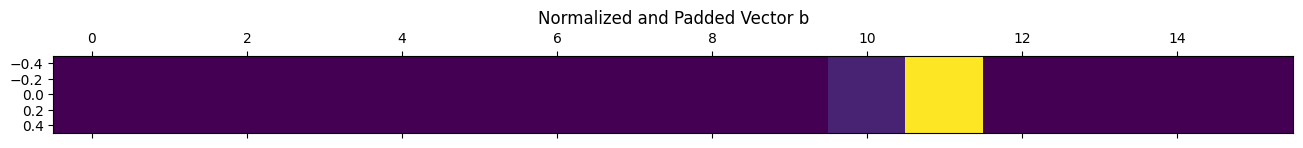

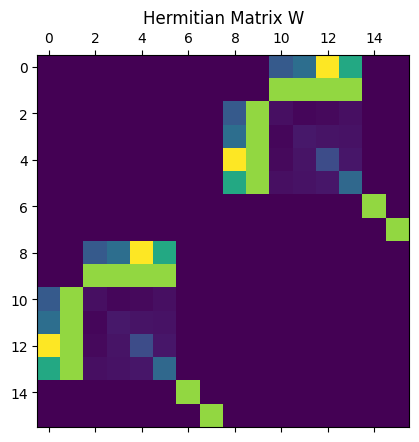

In [14]:
def to_hermitian(A):
    N = A.shape[0]
    A_hermitian = np.concatenate(
        [
            np.concatenate([np.zeros((N, N)), A.transpose().conj()], axis=1),
            np.concatenate([A, np.zeros((N, N))], axis=1),
        ]
    )
    return A_hermitian


N = W.shape[0]
b_new = np.concatenate([np.zeros((2 * N - len(b_normalized), 1)), b_normalized])
plt.matshow(b_new.transpose())
plt.title("Normalized and Padded Vector b")
plt.show()

W_hermitian = to_hermitian(W)
plt.matshow(W_hermitian)
plt.title("Hermitian Matrix W")
plt.show()

### 4) Rescaled Matrix

If the eigenvalues of matrix $A$ lie within the interval $[w_{\min}, w_{\max}]$, we can handle this by transforming the matrix and then reverting the result.
The transformation is defined as follows:

$$
\tilde{A} = (A - w_{\min} I)\left(1 - \frac{1}{2^{m}}\right)\frac{1}{w_{\max} - w_{\min}}.
$$

In this case, the eigenvalues of $\tilde{A}$ fall within the interval $[0,1)$. The relationship with the eigenvalues of the original matrix is given by:

$$
\lambda = (w_{\max} - w_{\min})\tilde{\lambda}\left[\frac{1}{1 - \frac{1}{2^{m}}}\right] + w_{\min},
$$

Where $\tilde{\lambda}$ is the eigenvalue of $\tilde{A}$ obtained by the QPE (Quantum Phase Estimation) algorithm.

This correspondence between eigenvalues is used in the formula for eigenvalue inversion within the `AmplitudeLoading` function.

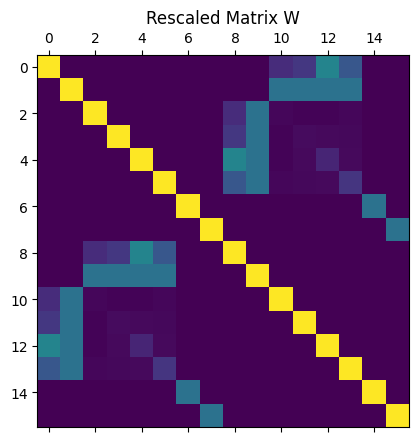

In [15]:
def condition_number(A):
    w, _ = np.linalg.eig(A)
    return max(np.abs(w)) / min(np.abs(w))


QPE_RESOLUTION_SIZE = 6

assert QPE_RESOLUTION_SIZE > np.log2(
    condition_number(W)
), "condition number is too big, and QPE resolution cannot hold all eigenvalues"

w, v = np.linalg.eig(W_hermitian)
w_max = np.max(w)
w_min = np.min(w)
mat_shift = -w_min
# assures eigenvalues in [0,1-1/2^QPE_SIZE]
mat_rescaling = (1 - 1 / 2**QPE_RESOLUTION_SIZE) / (w_max - w_min)
# this is the minimal eigenvalue which can be resolved by the QPE
min_possible_w = (w_max - w_min) / 2**QPE_RESOLUTION_SIZE

W_rescaled = (
    W_hermitian + mat_shift * np.identity(W_hermitian.shape[0])
) * mat_rescaling
W_rescaled = W_rescaled.real

# verifying that the matrix is symmetric and has eigenvalues in [0,1)
if not np.allclose(W_rescaled, W_rescaled.T, rtol=1e-6, atol=1e-6):
    raise Exception("The matrix is not symmetric")

w_rescaled, _ = np.linalg.eig(W_rescaled)

for lam in w_rescaled:
    if lam < -1e-6 or lam >= 1:
        raise Exception("Eigenvalues are not in (0,1)")

plt.matshow(W_rescaled)
plt.title("Rescaled Matrix W")
plt.show()

## Defining HHL Algorithm for the Quantum Solution
This section is based on Classiq HHL in the user guide, [here](https://github.com/Classiq/classiq-library/blob/main/tutorials/technology_demonstrations/hhl/hhl_example.ipynb) and [here](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb).

Note the rescaling in `simple_eig_inv` based on the matrix rescaling.

In [16]:
from classiq import *


@qfunc
def simple_eig_inv(
    gamma: float,
    delta: float,
    c_param: float,
    phase: QNum,
    indicator: Output[QBit],
):
    allocate(indicator)
    assign_amplitude_table(
        lookup_table(lambda p: np.clip(c_param / ((gamma * p) + delta), -1, 1), phase),
        phase,
        indicator,
    )

In [17]:
import numpy as np
import scipy

exponentiation_W_rescaled = scipy.linalg.expm(1j * 2 * np.pi * W_rescaled).tolist()
b_list = np.concatenate(b_new).tolist()

In [18]:
@qfunc
def main(
    indicator: Output[QBit],
    res: Output[QNum],
    rescaled_eig: Output[QNum],
) -> None:
    allocate(QPE_RESOLUTION_SIZE, False, QPE_RESOLUTION_SIZE, rescaled_eig)
    prepare_amplitudes(b_list, 0, res)
    within_apply(
        lambda: qpe(
            unitary=lambda: unitary(exponentiation_W_rescaled, res),
            phase=rescaled_eig,
        ),
        lambda: simple_eig_inv(
            gamma=mat_rescaling ** (-1),
            delta=-mat_shift,
            c_param=min_possible_w,
            phase=rescaled_eig,
            indicator=indicator,
        ),
    )


MAX_WIDTH_BASIC = 18
constraints = Constraints(max_width=MAX_WIDTH_BASIC)
# preferences = Preferences(
#     optimization_level=0, optimization_timeout_seconds=90, transpilation_option="none"
# )
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)
execution_preferences = ExecutionPreferences(
    num_shots=1, backend_preferences=backend_preferences
)

qmod_hhl_basic = create_model(
    main,
    constraints=constraints,
    # preferences=preferences,
    execution_preferences=execution_preferences,
)

# write_qmod(qmod_hhl_basic, "hhl_lanchester", decimal_precision=15, symbolic_only=False)
write_qmod(qmod_hhl_basic, "hhl_portfolio", decimal_precision=15, symbolic_only=False)
qprog = synthesize(qmod_hhl_basic)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36pWFrJtgOWTmLMPpdlgzZkX3lL


In [19]:
execution_job_id = execute(qprog)
result = execution_job_id.result_value()

In [20]:
filtered_hhl_statevector = dict()
for sample in result.parsed_state_vector:
    if sample.state["indicator"] == 1 and sample.state["rescaled_eig"] == 0:
        filtered_hhl_statevector[sample.state["res"]] = sample.amplitude

states = sorted(filtered_hhl_statevector)
raw_qsol = np.array([filtered_hhl_statevector[s] for s in states])

In [21]:
qsol_hermitian = raw_qsol / (min_possible_w)
print(qsol_hermitian)

[ 5.04843302e-01-4.24758417e-01j -5.39469162e-01+4.53891467e-01j  3.96816826e+00-3.33868521e+00j -4.80876510e+00+4.04593552e+00j  2.51851595e-01-2.11899582e-01j  5.87187622e-01-4.94040197e-01j
  6.69687142e-14-8.07471979e-14j  6.66633726e-14-1.62478643e-14j -3.00024517e-14-3.06827250e-14j  5.74857250e-14+5.17999268e-14j -6.07267088e-14-1.05229949e-13j  2.98997704e-14-1.23220749e-14j
 -6.52341354e-14+1.61845207e-13j  8.24096012e-14-7.75399996e-14j -5.97477789e-15-1.03473592e-14j  3.89251848e-14-2.82226281e-15j]


In [22]:
x_classical = np.array([s[0] for s in np.linalg.solve(W_hermitian, b_new)])
x_classical = x_classical[:6].reshape(-1)


x_hhl = qsol_hermitian[:6].reshape(-1)


alpha = (x_hhl @ x_classical) / (x_hhl @ x_hhl)
x_hhl_rescaled = alpha * x_hhl

print(
    "rel error:",
    np.linalg.norm(x_hhl_rescaled - x_classical) / np.linalg.norm(x_classical),
)

rel error: 0.07994134845079175


In [23]:
print("x-HHL", x_hhl_rescaled.real)
print("x-classical", x_classical.real)

x-HHL [-1.27111788  1.35830048 -9.99123808 12.10773179 -0.63412363 -1.47844823]
x-classical [ -0.66823233   0.65447749 -10.32197741  12.04823131  -0.9782884   -0.7479655 ]


In [24]:
x_exact = np.linalg.lstsq(W_hermitian, b_new, rcond=0)[0]
x_exact = x_exact[:6].reshape(-1)

<Axes: >

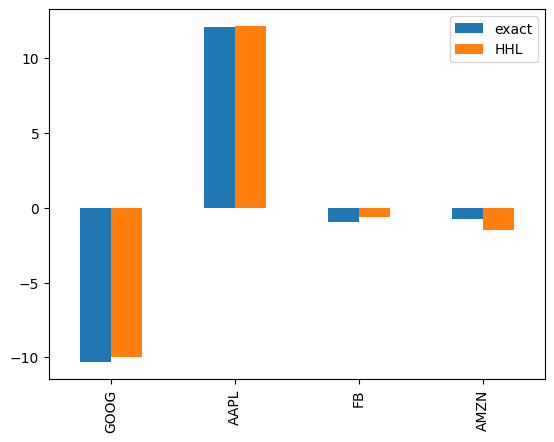

In [25]:
import pandas as pd

w_opt_HHL = x_hhl_rescaled.real[2:6]
w_opt_exact = x_classical[2:6]  # x_exact[2:6]
w_opt = pd.DataFrame(
    np.vstack([w_opt_exact, w_opt_HHL]).T,
    index=["GOOG", "AAPL", "FB", "AMZN"],
    columns=["exact", "HHL"],
)
w_opt.plot.bar()

The next step is to calculate the "total portfolio value for each day."
This operation involves multiplying the price of each asset by its weight and summing them up. Expressed as a formula, it looks like this:

$$
\text{Portfolio Value} = w_{\text{AAPL}} \cdot P_{\text{AAPL}} + w_{\text{AMZN}} \cdot P_{\text{AMZN}} + w_{\text{NVDA}} \cdot P_{\text{NVDA}} + w_{\text{TSLA}} \cdot P_{\text{TSLA}}
$$

For example, if we assume:
$$
w = [0.4, 0.3, 0.2, 0.1]
$$

Then:

$$
\text{Portfolio Value} = 0.4A + 0.3B + 0.2C + 0.1D
$$

This gives you the general idea.

To perform this calculation automatically for all dates, you can write it in a single line of Python code as follows:

In [26]:
pf_value = df.values.dot(w_opt)
pf_value = pd.DataFrame(df.values.dot(w_opt), index=df.index, columns=["exact", "HHL"])
pf_value.head()

,exact,HHL
Date,,
2024-01-02,-324.759439,-419.912518
2024-01-03,-320.093201,-408.711715
2024-01-04,-343.184525,-432.274351
2024-01-05,-328.392916,-416.982638
2024-01-08,-331.973892,-419.975494


In [27]:
pf_value["exact"] = pf_value["exact"] / pf_value["exact"].iloc[0]
pf_value["HHL"] = pf_value["HHL"] / pf_value["HHL"].iloc[0]

print(pf_value.tail())

               exact       HHL
Date                          
2024-12-23  1.139696  1.284024
2024-12-24  1.158997  1.350748
2024-12-26  1.239495  1.398706
2024-12-27  1.192851  1.329092
2024-12-30  1.145109  1.269991


<Axes: xlabel='Date'>

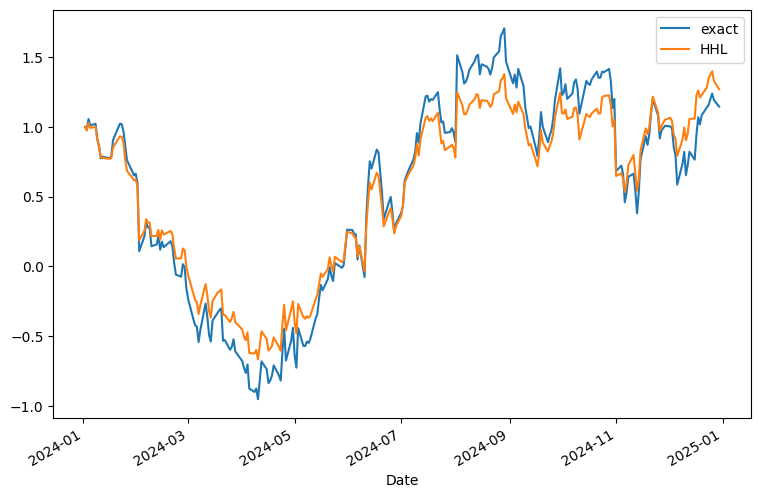

In [28]:
pf_value.plot(figsize=(9, 6))

## Reference 

- [1] P. Rebentrost and S. Lloyd, “Quantum computational finance: quantum algorithm for portfolio optimization“, https://arxiv.org/abs/1811.03975
- [2] 7-3. Portfolio optimization using HHL algorithm: https://dojo.qulacs.org/en/latest/notebooks/7.3_application_of_HHL_algorithm.html